# The gap effect of the rudder

In [1]:
%load_ext kedro.extras.extensions.ipython
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
#%config Completer.use_jedi = False

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/extra ]8;id=33275;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=369201;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             s/extensions/ipython.py:19: KedroDeprecationWarning:                                  
                             kedro.extras.extensions.ipython should be accessed only using the                     
                             alias kedro.ipython. The unaliased name will be removed in Kedro                      
                             0.19.0.                                                                               
                               warnings.warn(                                                                      
                                                                                                                   

                    INFO     Resolved project path as: /home/maa/dev/PHD.                           ]8;id=70135;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=748075;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#139\139]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/frame ]8;id=755407;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=52506;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             work/startup.py:99: KedroDeprecationWarning: project_version in                       
                             pyproject.toml is deprecated, use kedro_init_version instead                          
                               warnings.warn(                                                                      
                                                                                                                   

[02/12/24 15:28:05] WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/pa ]8;id=411143;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=867923;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rtitioned_dataset.py:200: KedroDeprecationWarning:                                    
                             'PartitionedDataset' has been moved to `kedro-datasets` and will be                   
                             removed in Kedro 0.19.0.                                                              
                               warnings.warn(                                                                      
                                                                                                                   

                    INFO     Kedro project phd                                                      ]8;id=571614;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=796469;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#108\108]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=574914;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=471291;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#109\109]8;;\
                             'pipelines'                                                                           

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
import sympy as sp
from vessel_manoeuvring_models.symbols import *
import vessel_manoeuvring_models.symbols as symbols
from IPython.display import display
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify, get_function_subs, remove_functions

from phd.visualization.plot_prediction import plot_total_force, plot_force_components, predict
from sklearn.metrics import r2_score, mean_absolute_error
from vessel_manoeuvring_models.parameters import df_parameters
p = df_parameters["symbol"]

import logging
log = logging.getLogger()
handler = log.handlers[0]
handler.setLevel(logging.ERROR)  # Remove info 

import matplotlib.pyplot as plt


import yaml

with open('styles.yml', 'r') as file:
    styles = yaml.safe_load(file)
    
import paper
from paper import save_fig, save_eq

In [3]:
#%reload_kedro
ship='wPCC'
ship_data = catalog.load(f"{ship}.ship_data")
df_VCT = catalog.load(f"{ship}.df_VCT_scaled")

In [4]:
model = catalog.load(f"{ship}.models_VCT")['semiempirical_covered']()

In [5]:
df = df_VCT.groupby(by='test type').get_group('Rudder angle').sort_values(by='delta')

In [6]:
N = 100
df_extrapolation = pd.DataFrame(np.tile(df.iloc[-1].values,(N,1)), columns=df.columns)
for key in df_extrapolation:
    df_extrapolation[key] = df_extrapolation[key].astype(df[key].dtype)
df_extrapolation['delta'] = np.linspace(0,np.deg2rad(30),N)
#df_extrapolation['delta']*=-1

In [7]:
df_extrapolation_prediction = predict(model=model, data=df_extrapolation)

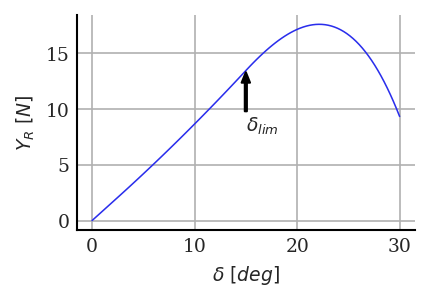

In [8]:
fig,ax=plt.subplots()
paper.scale_figure(fig,scale=0.5)
#ax.plot(np.rad2deg(df['delta']),df['Y_R'])
ax.plot(np.rad2deg(df_extrapolation_prediction['delta']),df_extrapolation_prediction['Y_R']);
ax.grid()
ax.set_xlabel(r'$\delta$ $[deg]$')
ax.set_ylabel(r'$Y_R$ $[N]$')

delta_lim = model.parameters['delta_lim']
i = (df_extrapolation_prediction['delta'] - delta_lim).abs().idxmin()
ax.annotate(r'$\delta_{lim}$',xy=(np.rad2deg(delta_lim),df_extrapolation_prediction.loc[i]['Y_R']),xytext=(np.rad2deg(delta_lim),8),arrowprops=dict(facecolor='black', width=1, headwidth=4, headlength=5), size=9);
fig.savefig(paper.file_path_with_nb_ref("gap.svg"))